***
## Optimize sales operations by prioritizing dialing using machine learning
#### <font color=green>*Ranjeet Sandhu*</font>
***

### Contents

- **Data analysis & key findings**


- **Feature selection**


- **Data wrangling**
 - **Missing value handling** 
 - **Calculating sales probabilities for afid**
 - **Feature mapping**


- **Data cleaning**


- **Predictive modeling strategy**


- **Machine learning models' preformance analysis**


- **Model selection**


- **Conclusion**

---

In [1]:
########################################################
### Import Libraries
########################################################

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer

---

In [3]:
########################################################
### Import Dataset
########################################################

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [13, 13]
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [5]:
fileName = '/Users/ranjeetsandhu/Downloads/DataAssessment.xlsx'
dfCall = pd.read_excel(fileName, sheet_name="Call Facts", engine='openpyxl')
dfLead = pd.read_excel(fileName, sheet_name="Lead Facts", engine='openpyxl')

---

# Call & Lead Facts 

**Data Analysis & Key Findings**

- **Raw Data:**
 - Number of records in `leads facts` data: `31,020`.
 - Number of records in `call facts` data: `339,789`.
 - Number of sales in leads data are `1,087`.
 - Number of sales in Calls data are `1,648`.


- **Key Findings:**
 - The final sales disposition status in `lead facts` data is recorded based on the most recent call. Considering, the calls could be made after the sales have occured,`latest call disposition` status doesn't reflect if the lead was converted into sales or not. Hence, the disposition status from `call facts` for sale status was used as source of truth.
 - Current skill doesn't reflect the skill at the time of sale.
 - Call center dial attempts represent total number of calls made for each `dialer lead id`, it doesn't provide the information on total number of calls made upto the `sale dispo` status.


- **Data Preparation:**
 - The records with missing values for all features were dropped `207,627` from call facts data.
 - `3269` records where `callCenterLatestDispoGroup` values are missing, were dropped.
 - Multiple calls are made for each dialer lead id throughout lead lifecycle, therefore, the records were grouped by `dialer lead id`.
 - The total talk time, handle time, call skill & call attempts were derived based on the following logic:
   - **Sales occurred:** The data upto the point of `sale` was considered and the subsequent call records were ignored.
   - **Others:** All call records were considered.

---

In [6]:
########################################################
### Calls data aggregation and feature generation
########################################################

In [7]:
dfCall = dfCall[dfCall['cdsCallsFactId'].notnull()]

In [8]:
grouping = dfCall.groupby('dialerLeadId')

list_of_tuples = []
for dialer, group in grouping:
    if_sale = (group.dispoGroup == 'Sale').sum()
    if if_sale == 0:
        callSkill = float(group.tail(1).callSkill.values)
        callAttempts = float(group.tail(1).callAttemptNumber.values)
        tot_talkTime  = group.talkTimeSeconds.sum()
        tot_handleTime = group.handleTimeSeconds.sum()
        list_of_tuples.append((dialer, callSkill, callAttempts,
                               tot_talkTime, tot_handleTime))
    else:
        index = (group.dispoGroup == 'Sale').idxmax()
        df_sliced = group.loc[:index]
        callSkill = float(df_sliced.loc[df_sliced.dispoGroup == 'Sale',
                                        'callSkill'])
        callAttempts = float(df_sliced.loc[df_sliced.dispoGroup == 'Sale',
                                           'callAttemptNumber'])
        tot_talkTime = df_sliced.talkTimeSeconds.sum()
        tot_handleTime = df_sliced.handleTimeSeconds.sum()
        list_of_tuples.append((dialer, callSkill, callAttempts, tot_talkTime,\
                               tot_handleTime))
        
aggCalls = pd.DataFrame(list_of_tuples, columns=['dialerLeadId',
                                                 'callSkill',
                                                 'callAttempts',
                                                 'totalTalkTime',
                                                 'totalHandleTime'])

---

#### Association between total handle time & talk time

- The scatterplot shows a strong linear correlation. 
- Total handle time is equal or greater than talk time for all calls.

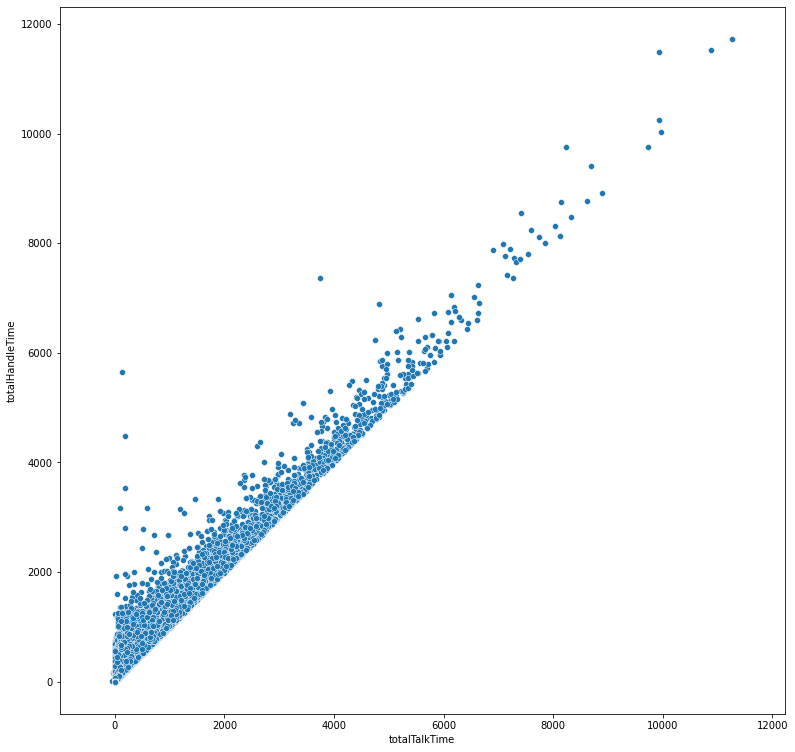

In [9]:
# Plot talk time vs handle time.
plt.axis('equal')
sns.scatterplot(x = 'totalTalkTime', y = 'totalHandleTime', data = aggCalls); 

---

In [10]:
########################################################
### Feature selection
########################################################

**The following features are selected for further data exploration and machine learning based on preliminary data analysis:**

- sourceSystem
- afid
- campaign_id
- originalContactType
- ageOnLeadGroup
- gender
- callCenterLeadCreatedReason
- callCenterMinutesToFirstDialAttempt
- callCenterLeadEverContacted
- callCenterLatestDispoGroup
- deliveryMethod
- everCallback

In [11]:
dfLead.rename(columns={'campaign id': 'campaign_id'}, inplace=True)

drop_col = ['cdsLeadFactId', 
            'sourceSystemId', 
            'cdsPersonId', 
            'dimProgramId', 
            'tztMarketingProject', 
            'omsMarketingProject', 
            'externalSystem', 
            'externalSystemId', 
            'leadDate',
            'leadDateKey', 
            'dimMarketingSourceId', 
            'productOfInterest', 
            'originalInboundDnis', 
            'leadTypeId', 
            'leadZip', 
            'tobacco', 
            'leadCost', 
            'callCenterLeadCloneSourceId', 
            'callCenterDialAttempts',
            'leadsReceived', 
            'leadsAccepted', 
            'leadsRejected', 
            'rejectType', 
            'rejectReason', 
            'callCenterLeadsTotal', 
            'callCenterLeadEverSold', 
            'callCenterLatestDispo', 
            'callCenterLatestDispoDescription', 
            'batchid',
            'currentSkill',
            'originalSkill',
            'expirationInDays', 
            'maxAttempts',
            'dailyMaxAttempts', 
            'leadType']

lead = dfLead.drop(drop_col, axis=1)

In [12]:
# Set indexes - dialerLeadId
lead = lead[lead['callCenterLatestDispoGroup'].notnull()]
lead.set_index('dialerLeadId', inplace=True)
aggCalls.set_index('dialerLeadId', inplace=True)

---

In [13]:
########################################################
### Join leads and calls data
########################################################

- Both datasets have same `dialer lead ids`. However, the leads data have unique dialer id records and hence, it will be used as a `primary key`.


- The `sale` disposition status in leads data was updated in accordance with calls data, using `dialer lead id` as a reference key.

In [14]:
# Unique values of dialerLeadId in both tables - 'Sale' disposition discrepancy

saleCallId = set(dfCall[dfCall['dispoGroup'] == 'Sale'].dialerLeadId)
saleLeadId = set(lead[lead['callCenterLatestDispoGroup'] == 'Sale'].index)
diffList = list(saleCallId.difference(saleLeadId))

lead_sale_data = lead.loc[diffList]

mask = (dfCall['dialerLeadId'].isin(diffList)) & \
       (dfCall['dispoGroup'] == 'Sale')
call_sale_data = dfCall[mask]

In [15]:
# Leads and Calls data where 'dialerLeadId' is associated with sale dispo group
# in calls data but not in leads data.

lead_skill = lead_sale_data[['callCenterLatestDispoGroup']]
call_skill = call_sale_data[['dialerLeadId', 'dispoDescription']]
lead_call_sales = pd.merge(lead_skill, call_skill, on = 'dialerLeadId')

In [16]:
# Update the leads sale disposition status

mask = lead.loc[diffList]
lead.loc[mask.index, 'callCenterLatestDispoGroup'] = 'Sale'

In [17]:
# Merge the Leads and Calls data frames on dialerLeadId index, keeping all
# records from Leads table

dfFinal = pd.merge(lead, aggCalls, on = 'dialerLeadId', how = 'left')

---

In [18]:
########################################################
### Missing values analysis and imputation
########################################################

 **Missing values count**

 - campaign_id: `5240`
 - gender: `4984`
 - ageOnLeadGroup: `3998`
 - afid: `135`
 - everCallback: `123`
 - callSkill: `17`

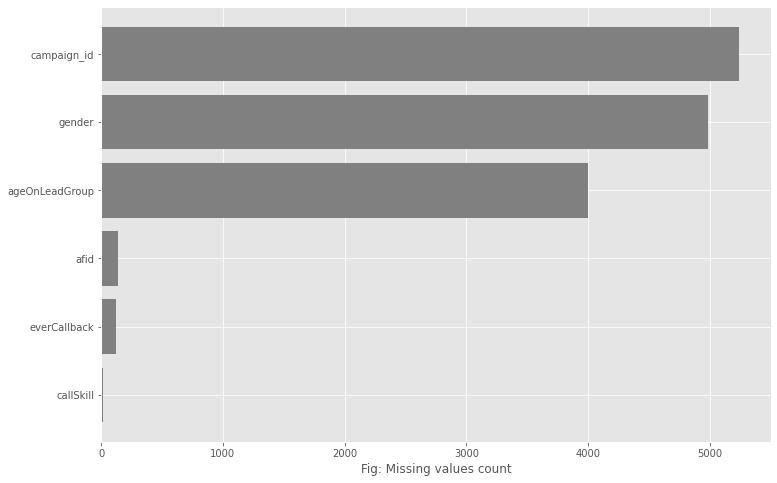

In [19]:
# Missing values count plot
nan_all = dfFinal.isna().sum()
missing = nan_all[nan_all != 0].sort_values()

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(missing.index, missing.values, color='gray')
ax.set_xlabel("Fig: Missing values count");

#### Impute missing values

- Missing values in `campaign_id` & `afid` are replaced with `999999`.


- Missing values in `gender` and `age group` feature are replaced with `U`.


- Drop records where `everCallback` & `callSkill` values are missing as these records constitute less than `0.05 %` of the data and no information about these values can be inferred from other features in either of the tables.

In [20]:
def replace_nulls(df, column):
    """Replaces missing values of categorical variable with U
       and numeric variable with 999999 
    """
    mask = df[column].isnull()
    if df[column].dtype == 'object':
        df.loc[mask, column] = 'U'
    else:
        df.loc[mask, column] = 999999
    return df

In [21]:
replace_nulls(dfFinal, 'campaign_id');
replace_nulls(dfFinal, 'afid');
replace_nulls(dfFinal, 'gender');
replace_nulls(dfFinal, 'ageOnLeadGroup');

In [22]:
complete_cases = (dfFinal['everCallback'].notnull()) & \
                 (dfFinal['callSkill'].notnull())
dfFinal = dfFinal[complete_cases]

---

In [23]:
########################################################
### Calculate probability of sales for afid
########################################################

**Calculate Probabilities**

- `afid` has `253` unique categories in the leads data and feature encoding techniques will result in feature space with large number of dimensions. The better alternative is replacement of `afid` values with sales probabilities.


- `afid` are mapped with `sale` dispo status and probabilities are computed for each afid.


- Probabilities of `afid` are set to zero if no sale has occurred.

In [24]:
df = dfFinal.reset_index()

sale_data = df[df['callCenterLatestDispoGroup'] == 'Sale']
mapping = sale_data.groupby('afid')\
                   .agg({'dialerLeadId':'count'})\
                   .apply(lambda x: x/x.sum())

mapping.rename(columns={'dialerLeadId': 'afid_sales_probability'}, inplace=True)
mapping = mapping.reset_index()

mapper_afid = dict()
for index, row in mapping.iterrows():
    mapper_afid[row['afid']] = row['afid_sales_probability']
    
df['afid_sales_probability'] = df['afid'].map(mapper_afid)

mask = df['afid_sales_probability'].isnull()
df.loc[mask,'afid_sales_probability'] = 0
df = df.drop('afid', axis=1)

In [25]:
mask = (df['callCenterLatestDispoGroup'] == 'Sale') | \
       (df['callCenterLatestDispoGroup'] == 'No Sale')
df = df[mask]

---

In [26]:
########################################################
### Categorical label mappings - dimension reduction
########################################################

**Mapping categorical labels**

- Campaign_id & Call skill features have 10 & 4 categories respectively, with very few records. Hence, they were combined into single categories.


- Call center lead created reason have multiple sub categories for `Draft` and `Clone`. These were combined into their repective parent categories.


- Individual age groups were mapped to four distinct groups - `Senior (61 & above)`, `MidAge (41 - 60)`, `Young (30 & below)` and `Unknown`.

In [27]:
# Combine small campaign ids into single category - zero
small_campaigns = [1, 2, 4, 6, 7, 10, 12, 13, 14, 16]
mask = df['campaign_id'].isin(small_campaigns)
df.loc[mask, 'campaign_id'] = 0

# Combine small callSkills into single category - zero
small_callSkills = [1, 12, 21]
mask = df['callSkill'].isin(small_callSkills)
df.loc[mask, 'callSkill'] = 0

In [28]:
# Combine Draft & Clone categories
df.loc[df.callCenterLeadCreatedReason.str.contains('Draft'),
       'callCenterLeadCreatedReason'] = 'Draft'
df.loc[df.callCenterLeadCreatedReason.str.contains('Clone'),
       'callCenterLeadCreatedReason'] = 'Clone'

In [29]:
# Mapping age-groups into 3 categories
mapping = {'61 - 70':'Senior', '71 - 80':'Senior', '81 - 90':'Senior',
           'Over 90':'Senior', '31 - 40':'MidAge', '41 - 50':'MidAge',
           '51 - 60':'MidAge', 'Under 20':'Young', '20 - 30':'Young',
           'U':'Unknown'}
           
df.replace(to_replace=df['ageOnLeadGroup'], value=mapping, inplace=True)   

In [30]:
# Change categorical features data types to object
convert_dict = {'campaign_id': object,
                'callCenterLeadEverContacted': object,
                'everCallback': object,
                'callSkill': object
               }

df = df.astype(convert_dict)

In [31]:
# Drop dialer lead id and handle time features
df.drop(['dialerLeadId', 'totalHandleTime'], axis=1, inplace=True)

# Rename target column for easy referencing
df.rename(columns={'callCenterLatestDispoGroup': 'target'}, inplace=True)

---

In [32]:
########################################################
### Class distribution summmary
########################################################

**Target class distribution**

- Final data for modeling has `11309` records and `15` features including the target variable.


- The class distribution is highly skewed as inferred from the following analysis.


- Final dataset has 4 numeric variables: mins to first dial, call attempts, total talk time and afid probabilities.


- The first 3 features are right skewed with majority of the values close to lower end of x-axis as shown by histogram plots.


- `Correlation` heat map shows no significant correlation among the numeric variables.

In [33]:
# summarize the class distribution
target = df['target'].values
counter = Counter(LabelEncoder().fit_transform(target))
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=9671, Percentage=85.440%
Class=1, Count=1648, Percentage=14.560%


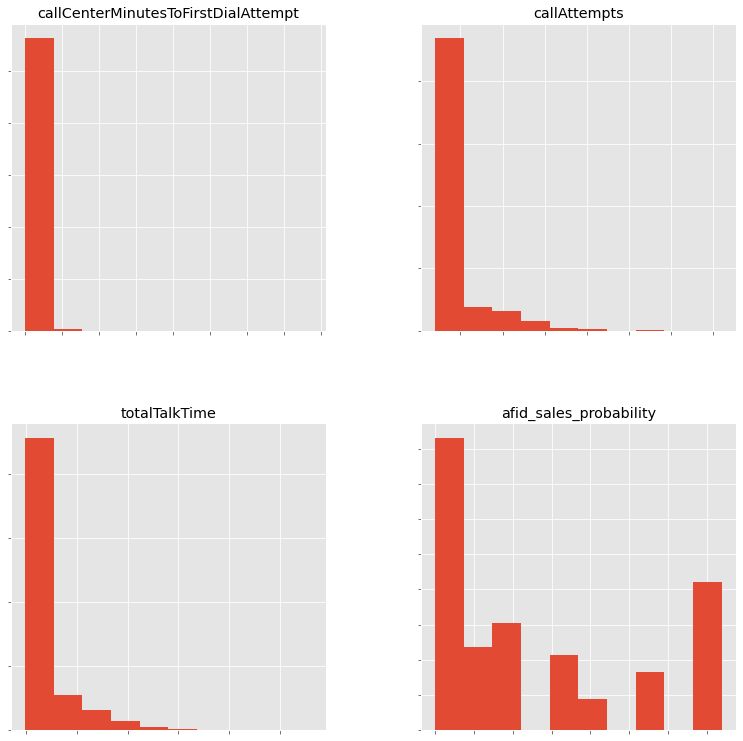

In [34]:
# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns
# select a subset of the dataframe with the chosen columns 
subset = df[num_ix]
# create a histogram plot of each numeric variable
ax = subset.hist()
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
plt.show()

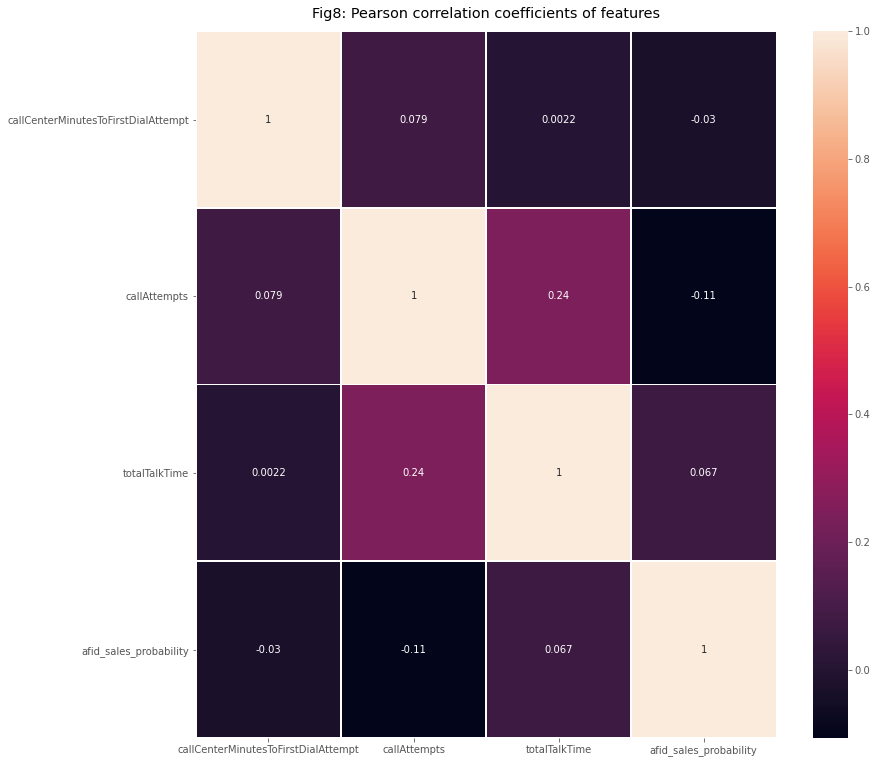

In [35]:
# Correlation Matrix
sns.heatmap(df[num_ix].corr(), annot=True, cbar=True, linewidths=0.5)
plt.title("Fig8: Pearson correlation coefficients of features",  y=1.01);

---

# Predictive Modeling Strategy

- The `predictor space` consists of `14` features out of which `10` features are categorical and `4` are numeric features.


- Categorical features are transformed using one hot encoding and numeric features are scaled for the final model.


- There are `11,319,` total number of `tidy data` samples for training, validating and scoring machine learning models. These samples are split into training and test data; training data consists of `9,055` (`80%`) and test data consists of `2,264` (`20%`) samples. Random state is set to reproduce the same data splits.


- Same `training` and `hold out` datasets are used for all machine learners.


- `5` fold `cross-validation` technique is used to obtain optimal scores.


- `F2` metric is used to evaluate and compare models' performance on test data.

In [36]:
########################################################
### Train, test stratified data split
########################################################

In [37]:
leads_x, leads_y = df.drop('target', axis=1), df['target']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(leads_x, leads_y,
                                                    stratify=leads_y, 
                                                    test_size=0.2,
                                                    random_state=1)

In [39]:
# summarize the class distribution - test data
target = y_test.values
counter = Counter(LabelEncoder().fit_transform(target))
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=1934, Percentage=85.424%
Class=1, Count=330, Percentage=14.576%


In [40]:
# summarize the class distribution - training data
target = y_train.values
counter = Counter(LabelEncoder().fit_transform(target))
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=0, Count=7737, Percentage=85.445%
Class=1, Count=1318, Percentage=14.555%


---

# Machine Learning models and performance analysis

#### Spot check classifiers to discover which algorithms perform well on our use case.


- **Linear Algorithms:** Logistic Regression (`LR`), Linear Discriminant Analysis(`LDA`) and Naive Bayes (`NB`).


- **Nonlinear Algorithms:** Classification and Regression Trees (`CART`), k-Nearest Neighbors (`KNN`) and Support Vector Classification (`SVC`).


- The algorithms were trained using default parameters.

---

In [41]:
########################################################
### Define functions for transformations and scoring
########################################################

In [42]:
def transform_dataset(X, y):
    """Transforms categorical features using one hot encoding
       and encodes the binary target variable. 
    """
    # select categorical features
    cat_ix = X.select_dtypes(include=['object']).columns
    ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix)],remainder='passthrough')
    # label encode the target variable to have the classes 0 and 1
    X = ct.fit_transform(X)
    y = LabelEncoder().fit_transform(y)
    return X, y

# calculate f2-measure
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

metric = make_scorer(f2_measure)

In [43]:
########################################################
### Transform training data and train models
########################################################

In [44]:
# Create encoded dataset
X_train_en, y_train_en = transform_dataset(X_train, y_train)

In [45]:
# Test options and evaluation metric
num_folds = 5
seed = 1
scoring = metric

In [46]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear'))) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

In [47]:
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
  cv_results = cross_val_score(model, X_train_en, y_train_en, cv=kfold,
                               scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.787613 (0.019487)
LDA: 0.761643 (0.019620)
KNN: 0.756371 (0.016681)
CART: 0.788034 (0.023922)
NB: 0.720646 (0.018645)
SVM: 0.393410 (0.027184)


In [48]:
########################################################
### Performance comparison of algorithms
########################################################

- **`LR` has highest `F2` followed by `CART`.** 


- **`LDA`, `KNN` have similar performance.**


- **`SVM` has a comparatively poor performance. As `SVM` is sensitive to features on different scales, standardizing the numeric features might improve its performance.**

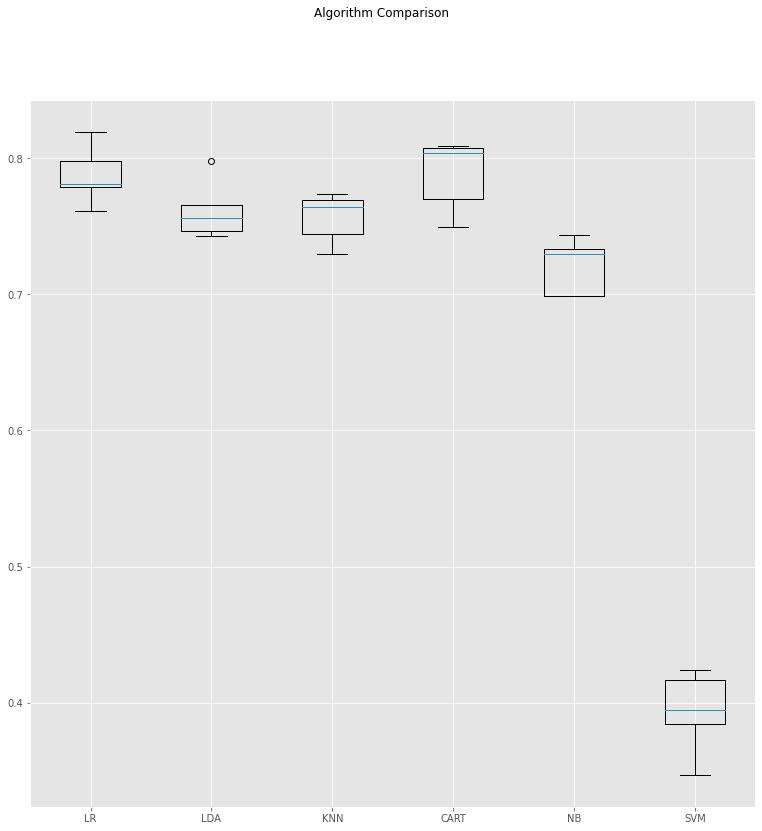

In [49]:
# Compare Algorithms
fig = plt.figure() 
fig.suptitle('Algorithm Comparison') 
ax = fig.add_subplot(111) 
plt.boxplot(results) 
ax.set_xticklabels(names) 
plt.show();

---

In [50]:
########################################################
### Transform training data
########################################################

In [51]:
# Modify the transform_dataset function to include names of categorical 
# and numeric variables.

def transform_dataset(X, y):
    # select categorical features
    cat_ix = X.select_dtypes(include=['object']).columns
    num_ix = X.select_dtypes(include=['int64', 'float64']).columns
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y, cat_ix, num_ix
    

# Create encoded dataset
X_train_en_s, y_train_en_s, cat_ix, num_ix = transform_dataset(X_train, y_train)

In [52]:
########################################################
### Standardize numeric variables and train algorithms
########################################################

In [53]:
# Define the transformer for pipeline
ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), 
                        ('n',StandardScaler(),num_ix)],
                         remainder='passthrough')

# One hot encode the categorical columns and standardize the numeric columns
pipelines = []

pipelines.append(('ohe_scaledLR', 
                  Pipeline([('c', ct),('LR', LogisticRegression(solver='liblinear'))]))) 
pipelines.append(('ohe_scaledLDA', 
                  Pipeline([('c', ct),('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ohe_scaledKNN', 
                  Pipeline([('c', ct),('KNN', KNeighborsClassifier())])))
pipelines.append(('ohe_scaledCART', 
                  Pipeline([('c', ct),('CART', DecisionTreeClassifier())])))
pipelines.append(('ohe_scaledNB', 
                  Pipeline([('c', ct),('NB', GaussianNB())])))
pipelines.append(('ohe_scaledSVM', 
                  Pipeline([('c', ct),('SVM', SVC(gamma='auto'))])))

results = []
names = []

for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_en_s, y_train_en_s, cv=kfold,
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ohe_scaledLR: 0.782636 (0.019320)
ohe_scaledLDA: 0.761643 (0.019620)
ohe_scaledKNN: 0.795415 (0.020039)
ohe_scaledCART: 0.783699 (0.016650)
ohe_scaledNB: 0.676549 (0.096593)
ohe_scaledSVM: 0.810198 (0.018324)


In [54]:
########################################################
### Performance comparison of algorithms
########################################################

- **`SVM` is the best performing model with tighter distribution of scores and highest mean scores.**


- **Performances of `KNN` & `SVM` have significantly improved after standardizing the numeric features.**


- **`NB` has a comparatively poor performance which has degraded in comparison to spot-check training.**

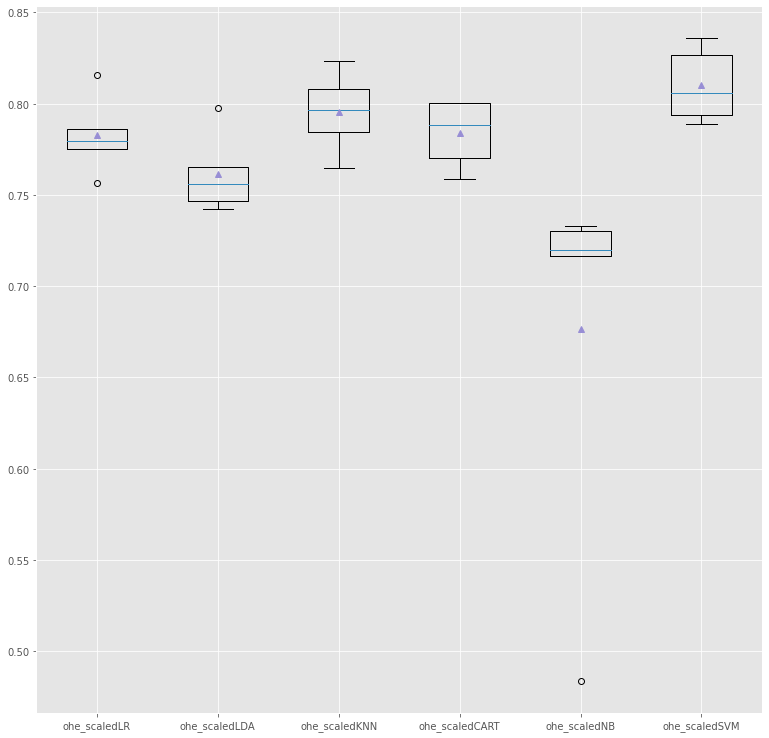

In [55]:
# plot the results
plt.boxplot(results, labels=names, showmeans=True) 
plt.show();

---

# Model of choice

- `SVM` is selected as the candidate model, based on its superior performance.


- `SVM` with default parameters was fitted to the whole training dataset.


- Numeric variables are standardized and `training data` categorical variables are encoded using one hot encoding. Same tranformation is applied to the hold out test data.

---

In [56]:
########################################################
### Feature encoding - One hot, standardize
########################################################

In [57]:
enc = OneHotEncoder(handle_unknown = 'ignore')
scaler = StandardScaler()

encoderFit = enc.fit(X_train_en_s[cat_ix])
encodedDF = encoderFit.transform(X_train_en_s[cat_ix]).toarray()

scalerFit = scaler.fit(X_train_en_s[num_ix])
scaledDF = scalerFit.transform(X_train_en_s[num_ix])

In [58]:
# combine categorical and numeric data arrays
trainingArray = np.hstack([encodedDF,scaledDF])

In [59]:
# Train the binary classifier
model = SVC(gamma='auto')
model.fit(trainingArray, y_train_en_s)

SVC(gamma='auto')

---

# Predict Sales

In [60]:
########################################################
### Test data transformations - One hot, standardize
########################################################

In [61]:
# Transform target variable
X_test_en_s, y_test_en_s, cat_ix, num_ix = transform_dataset(X_test, y_test)

In [62]:
# Encode features
encodedTestDF = encoderFit.transform(X_test_en_s[cat_ix]).toarray()
scaledTestDF = scalerFit.transform(X_test_en_s[num_ix])
testArray = np.hstack([encodedTestDF,scaledTestDF])

In [63]:
# Make sales predictions
predictions = model.predict(testArray)

In [64]:
########################################################
### Confusion Matrix & Classification Report
########################################################

In [65]:
print(confusion_matrix(y_test_en_s, predictions))

[[1883   51]
 [  61  269]]


In [66]:
print(classification_report(y_test_en_s, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1934
           1       0.84      0.82      0.83       330

    accuracy                           0.95      2264
   macro avg       0.90      0.89      0.90      2264
weighted avg       0.95      0.95      0.95      2264



---

# Conclusion

- **The model of choice: `SVM`.**


- **Model has predicted the sales in hold out test data with the precision of `84 %`.**


- **Recall is `84 %` indicating that model is equipped in detecting true positives with high accuracy and low false negative rate.**